##TODO: Introdução

In [ ]:
## Install Required Packs
# !pip install pandas
# !pip install numpy
# !pip install statsmodels
# !pip install matplotlib
# !pip install -U seaborn
# !pip install pingouin
# !pip install statstests
# !pip install scipy
# !pip install openpyxl

In [23]:
## Import Required Packs
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statstests.process import stepwise
from Utils.VariablesExtensions import VariablesExtensions
from Utils.GraphTools import GraphTools

In [24]:
## Load dataset (Source: https://www.kaggle.com/datasets/elakiricoder/jiffs-house-price-prediction-dataset)
house_dataframe = pd.read_excel("../Datasets/house_price.xlsx")

# Get Metric Variables
metric_indexes = [
  'land_size_sqm',
  'house_size_sqm',
  'no_of_rooms',
  'no_of_bathrooms',
  'distance_to_school',
  'house_age',
  'distance_to_supermarket_km',
  'crime_rate_index',
  'property_value']

metric_variables = house_dataframe[metric_indexes].describe()

print(metric_variables)

       land_size_sqm  house_size_sqm  no_of_rooms  no_of_bathrooms  \
count    4954.000000     4954.000000  4954.000000      4954.000000   
mean      250.131409      231.250908     3.788252         3.199839   
std       103.131939       94.571642     1.585371         1.602300   
min       100.000000       85.000000     1.000000         1.000000   
25%       180.000000      165.000000     3.000000         2.000000   
50%       235.000000      217.500000     4.000000         3.000000   
75%       295.000000      274.000000     5.000000         4.000000   
max       796.000000      760.000000     8.000000         9.000000   

       distance_to_school    house_age  distance_to_supermarket_km  \
count         4954.000000  4954.000000                 4954.000000   
mean             3.454219    11.444691                    3.508639   
std              2.007358     6.356991                    1.991266   
min              0.100000     1.000000                    0.100000   
25%              1.

In [25]:
## Get Nominal Variables 
nominal_indexes = [
  'large_living_room',
  'parking_space',
  'front_garden',
  'swimming_pool',
  'wall_fence',
  'water_front',
  'room_size_class']

VariablesExtensions.print_nominal_counts(
  dataFrame=house_dataframe,
  indexes=nominal_indexes)

## Binarization of nominal variables
dummified_dataframe = pd.get_dummies(
  data=house_dataframe, 
  columns=nominal_indexes, 
  drop_first=True,
  dtype='float')

large_living_room
Yes    3586
No     1368
Name: count, dtype: int64
parking_space
Yes    3784
No     1170
Name: count, dtype: int64
front_garden
Yes    3109
No     1845
Name: count, dtype: int64
swimming_pool
Yes    3060
No     1894
Name: count, dtype: int64
wall_fence
Yes    3123
No     1831
Name: count, dtype: int64
water_front
No     4713
Yes     241
Name: count, dtype: int64
room_size_class
Two      1779
One      1460
Three    1198
Zero      517
Name: count, dtype: int64


In [31]:
target_index = 'property_value'
expresion = VariablesExtensions.get_regression_command_string(
  dataFrame=dummified_dataframe,
  target_index=target_index)
print(expresion)

property_value ~ land_size_sqm + house_size_sqm + no_of_rooms + no_of_bathrooms + distance_to_school + house_age + distance_to_supermarket_km + crime_rate_index + large_living_room_Yes + parking_space_Yes + front_garden_Yes + swimming_pool_Yes + wall_fence_Yes + water_front_Yes + room_size_class_Three + room_size_class_Two + room_size_class_Zero


In [32]:
## Calculate model using multiple linear regression
model = sm.OLS.from_formula(
  formula = expresion,
  data=dummified_dataframe).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_value   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.712e+04
Date:                Mon, 26 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:04:48   Log-Likelihood:                -52279.
No. Observations:                4954   AIC:                         1.046e+05
Df Residuals:                    4936   BIC:                         1.047e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.511e+04    622.023     24.297      0.000    1.39e+04    1.63e+04
land_size_sqm                832.1278     10.241     81.253      0.000     812.050     852.205
house_size_sqm               -90.7533     11.000     -8.250      0.000    -112.318     -69.189
no_of_rooms                 -823.2572    257.471     -3.197      0.001   -1328.014    -318.500
no_of_bathrooms              656.4204    118.089      5.559      0.000     424.914     887.927
distance_to_school         -2728.7767     65.809    -41.465      0.000   -2857.792   -2599.762
house_age                   -633.3564     20.757    -30.512      0.000    -674.050    -592.663
distance_to_supermarket_km -1324.1477     66.332    -19.963      0.000   -1454.187   -1194.108
crime_rate_index           -4145.9526     76.055    -54.512      0.000   -4295.055   -3996.850
large_living_room_Yes       3266.3280    333.930      9.781      0.000    2611.677    3920.979
parking_space_Yes           6037.6194    373.297     16.174      0.000    5305.792    6769.447
front_garden_Yes            6922.1240    348.867     19.842      0.000    6238.189    7606.059
swimming_pool_Yes           1.681e+04    349.114     48.137      0.000    1.61e+04    1.75e+04
wall_fence_Yes              1.797e+04    330.799     54.315      0.000    1.73e+04    1.86e+04
water_front_Yes             3.027e+04    614.753     49.236      0.000    2.91e+04    3.15e+04
room_size_class_Three      -6050.6866    375.891    -16.097      0.000   -6787.601   -5313.772
room_size_class_Two         3584.3676    333.956     10.733      0.000    2929.665    4239.071
room_size_class_Zero         977.5106    483.470      2.022      0.043      29.694    1925.328
==============================================================================
Omnibus:                      661.647   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3463.823
Skew:                          -0.532   Prob(JB):                         0.00
Kurtosis:                       6.956   Cond. No.                     1.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
## Analyzing the model using the sample observations
model_analysis = pd.DataFrame()
model_analysis['sample_values'] = house_dataframe[target_index]
model_analysis['fitted_values'] = model.fittedvalues
model_analysis['residual_values'] = model.resid
model_analysis['residual_percent'] = (model.resid/house_dataframe[target_index]) * 100

print(model_analysis)

      sample_values  fitted_values  residual_values  residual_percent
0            165432  168325.030943     -2893.030943         -1.748773
1            187043  182888.549025      4154.450975          2.221121
2            148658  140170.626731      8487.373269          5.709328
3            123785  117235.256460      6549.743540          5.291226
4            156470  160749.657372     -4279.657372         -2.735130
...             ...            ...              ...               ...
4949         235882  249932.627135    -14050.627135         -5.956634
4950         290995  290704.026195       290.973805          0.099993
4951         106428  114302.010755     -7874.010755         -7.398439
4952         107579  149308.555170    -41729.555170        -38.789685
4953         537980  565176.366467    -27196.366467         -5.055275

[4954 rows x 4 columns]


#%% Alguns coeficientes podem apresentar uma interpretação "inesperada"

# Exemplos:
    ## quanto maior o tamanho da casa, menor o preço (ceteris paribus)
    ## quanto mais quartos, menor o preço (ceteris paribus)
    
# É importante notar que os resultados são interpretados de forma multivariada
    ## o resultado ocorre na presença das demais variáveis
    
#%% Matriz de correlações de Pearson entre variáveis métricas

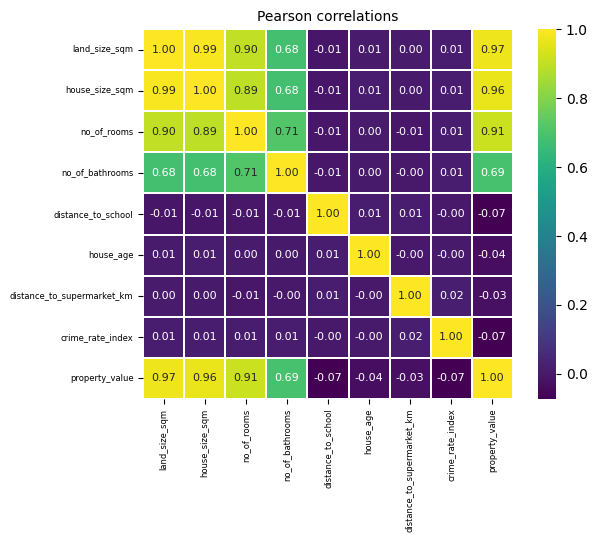

In [30]:
corretation_matrix = house_dataframe[metric_indexes].corr()
##print(metric_indexes_correlate)

GraphTools.generate_graph(
  dataFrame=corretation_matrix,
  title='Pearson correlations')

#%% Criando nova da fórmula

# 'land_size_sqm' tem correlação elevada com 'house_size_sqm' e 'no_of_rooms'
# Vamos remover o tamanho do terreno do modelo

In [35]:
new_expresion = VariablesExtensions.get_regression_command_string(
  dataFrame=dummified_dataframe,
  target_index=target_index,
  columns_to_remove=['land_size_sqm'])

new_model = sm.OLS.from_formula(formula = new_expresion,
                                data=dummified_dataframe).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_value   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 1.215e+04
Date:                Mon, 26 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:07:24   Log-Likelihood:                -54383.
No. Observations:                4954   AIC:                         1.088e+05
Df Residuals:                    4937   BIC:                         1.089e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.211e+04    949.228     12.755      0.000    1.02e+04     1.4e+04
house_size_sqm               762.7988      4.987    152.947      0.000     753.021     772.576
no_of_rooms                 2486.1888    388.649      6.397      0.000    1724.264    3248.114
no_of_bathrooms              908.8271    180.464      5.036      0.000     555.037    1262.617
distance_to_school         -2804.9083    100.595    -27.883      0.000   -3002.119   -2607.698
house_age                   -647.5722     31.732    -20.408      0.000    -709.780    -585.364
distance_to_supermarket_km -1172.5051    101.364    -11.567      0.000   -1371.223    -973.787
crime_rate_index           -4159.3638    116.269    -35.774      0.000   -4387.302   -3931.426
large_living_room_Yes       2228.1288    510.118      4.368      0.000    1228.071    3228.186
parking_space_Yes           1.248e+04    557.657     22.377      0.000    1.14e+04    1.36e+04
front_garden_Yes            5117.9401    532.246      9.616      0.000    4074.502    6161.379
swimming_pool_Yes           1.409e+04    531.259     26.527      0.000    1.31e+04    1.51e+04
wall_fence_Yes              1.631e+04    504.741     32.311      0.000    1.53e+04    1.73e+04
water_front_Yes             2.991e+04    939.773     31.825      0.000    2.81e+04    3.18e+04
room_size_class_Three      -6411.2564    574.600    -11.158      0.000   -7537.728   -5284.785
room_size_class_Two         3890.6076    510.500      7.621      0.000    2889.801    4891.414
room_size_class_Zero        1274.3623    739.079      1.724      0.085    -174.562    2723.286
==============================================================================
Omnibus:                      359.721   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1346.430
Skew:                           0.288   Prob(JB):                    4.23e-293
Kurtosis:                       5.488   Cond. No.                     1.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#%% Coeficientes

# Note que o 'house_size_sqm' e 'no_of_rooms' agora têm impactos positivos

#%% Realizando predições para outras observações (modelo original)

# Qual é o preço médio estimado para uma casa com:
    # tamanho do terreno (m²) = 350
    # tamanho da casa (m²) = 200
    # quantidade de quartos = 3
    # quantidade de banheiros = 3
    # distância até a escola (km) = 4.5
    # idade da casa (anos) = 5
    # distância até o mercado (km) = 1.0
    # indicador de criminalidade da região = 1.20
    # sala ampla: sim
    # garagem: sim
    # jardim frontal: sim
    # piscina: sim
    # cercado: não
    # vista para lagos/rios: não
    # classificação dos quartos: classe 2

In [ ]:


# Utilizando a função "predict"
obs_predict = pd.DataFrame({'land_size_sqm': [350],
                            'house_size_sqm': [200], 
                            'no_of_rooms': [3], 
                            'no_of_bathrooms': [3],
                            'distance_to_school': [4.5], 
                            'house_age': [5], 
                            'distance_to_supermarket_km': [1.0],
                            'crime_rate_index': [1.2], 
                            'large_living_room_Yes': [1],
                            'parking_space_Yes': [1], 
                            'front_garden_Yes': [1], 
                            'swimming_pool_Yes': [1],
                            'wall_fence_Yes': [0],
                            'water_front_Yes': [0], 
                            'room_size_class_Three': [0],
                            'room_size_class_Two': [1], 
                            'room_size_class_Zero': [0]})

print(f'preço estimado: {round(reg_casas.predict(obs_predict)[0],2)}')

#%% Comparando graficamente os ajustes dos modelos

sns.regplot(casas, x='property_value', y='fitted', marker='o', color='purple', scatter_kws={'s':0.50}, line_kws={'color':'red', 'lw':2})
plt.title('Análise Gráfica do Ajuste', fontsize=10)
plt.xlabel('Preço Observado', fontsize=10)
plt.ylabel('Preço Previsto pelo Modelo', fontsize=10)
plt.tick_params(labelsize=6)
plt.axline((0, 0), (max(casas['property_value']), max(casas['property_value'])), linewidth=1, color='grey')
plt.show()
